<a href="https://colab.research.google.com/github/DATA601-CustSegment-Nov2025-to-Feb2026/New-CustSegment-Project/blob/Andy_test/05_K_means_clustering_2nd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

from google.colab import drive

In [20]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
df_filepath = '/content/drive/MyDrive/0. Colab Notebooks (DATA 60X Project)/2. Preprocessed Datasets/customer_segmentation_after_preprocessing.csv'

In [22]:
# Display first 5 rows of the dataset
df = pd.read_csv(df_filepath)
df.head()

,household_key,age_encoded,income_encoded,household_size_encoded,kid_category_encoded,recency,frequency,monetary,retail_discount_mean,retail_discount_usage_proportion,...,alcohol_proportion,deli & bakery_proportion,entertainment & leisure_proportion,general_grocery_proportion,health_personal_care_proportion,home & lifestyle_proportion,meat_proportion,miscellaneous & services_proportion,produce_proportion,seafood_proportion
0,1,2.0,-0.333333,0.0,0.0,0.489861,-0.621099,-0.087203,-0.549338,-0.459021,...,0.041404,1.277385,0.053773,0.895717,0.950963,0.090203,0.724057,0.511598,0.932404,-3.621881
1,7,0.0,0.000000,0.0,0.0,0.000000,-1.136685,-0.358394,-0.737420,-0.420944,...,-0.068422,0.250714,-0.057319,0.367726,0.847179,0.043339,0.057966,-0.238082,0.445438,-0.495107
2,8,-2.0,-0.666667,0.5,1.0,0.489861,-0.263006,0.192638,0.216292,0.127897,...,1.189880,-0.578625,-0.289342,-0.635065,-0.699947,0.196379,-0.616372,-0.611474,-0.754490,-0.268544
3,13,-2.0,0.333333,1.0,2.0,0.000000,0.815617,1.220412,0.796188,0.198222,...,-0.129866,-0.573550,-0.119470,0.077653,0.626571,0.156368,-0.418512,1.215299,-0.426007,-0.049511
4,16,0.0,0.000000,-0.5,0.0,1.192513,-0.448174,-1.235709,-1.055914,-1.273896,...,0.152564,2.071352,0.166213,1.415026,1.086591,-0.864491,1.165722,1.238202,1.401472,-3.320718


In [23]:
# Install required packages
!pip install kneed -q

## Cell 1: Setup and Data Loading

In [24]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')


# print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
# print("\nFirst 5 rows:")
# print(df.head())
# print("\nData types:")
# print(df.dtypes)
# print("\nMissing values:")
# print(df.isnull().sum())

## Cell 2: Initialize Clustering Pipeline Class (Part 1)

In [25]:
class AdvancedClusteringPipeline:
    """
    Advanced clustering pipeline focused on K-means clustering and hyperparameter tuning
    Assumes data is already preprocessed and scaled
    """

    def __init__(self, df: pd.DataFrame, random_state: int = 42):
        """
        Initialize the clustering pipeline

        Parameters:
        -----------
        df : pd.DataFrame
            Input DataFrame with customer data (already scaled)
        random_state : int, default=42
            Random seed for reproducibility
        """
        self.df = df.copy()
        self.random_state = random_state
        self.results = {}
        self.best_models = {}
        self.feature_groups = self._define_feature_groups()

    def _define_feature_groups(self):
        """
        Define different feature groups for clustering
        Based on the provided dataset structure
        """
        # Get all feature columns (exclude household_key)
        all_features = [col for col in self.df.columns if col != 'household_key']

        # Define feature groups based on business logic
        feature_groups = {
            'RFM': [
                'recency',
                'frequency',
                'monetary'
                ],

            'Demographics': [
                'age_encoded',
                'income_encoded',
                'household_size_encoded',
                'kid_category_encoded'
                ],

            'Customer_Behavior': [
                'retail_discount_mean',
                'retail_discount_usage_proportion',
                'retail_discount_no_usage_proportion',
                'coupon_discount_mean',
                'coupon_discount_usage_proportion',
                'coupon_discount_no_usage_proportion',
                'did_not_receive_campaign_and_no_coupons_proportion',
                'received_campaign_and_16_coupons_proportion',
                'received_campaign_and_all_coupons_proportion',
                'afternoon_proportion',
                'evening_proportion',
                'midnight_proportion',
                'morning_proportion',
                'night_proportion',
                'displayed_proportion',
                'missing_display_info_proportion',
                'not_displayed_proportion',
                'missing_advertisment_info_proportion',
                'not_on_advertisement_proportion',
                'on_advertisement_proportion'
                ],

            'Product_Preference': [
                'national_proportion',
                'private_porportion',
                'alcohol_proportion',
                'deli & bakery proportion',
                'entertainment & leisure_proportion',
                'general_grocery_proportion',
                'health_personal_care_proportion',
                'home & lifestyle_proportion',
                'meat_proportion',
                'miscellaneous & services_proportion',
                'produce_proportion',
                'seafood_proportion'
                ],

            'RFM_Demographic': [
                'recency',
                'frequency',
                'monetary',
                'age_encoded',
                'income_encoded',
                'household_size_encoded',
                'kid_category_encoded'
                ],

            'RFM_Customer_Behavior': [
                'recency',
                'frequency',
                'monetary',
                'retail_discount_mean',
                'retail_discount_usage_proportion',
                'retail_discount_no_usage_proportion',
                'coupon_discount_mean',
                'coupon_discount_usage_proportion',
                'coupon_discount_no_usage_proportion',
                'did_not_receive_campaign_and_no_coupons_proportion',
                'received_campaign_and_16_coupons_proportion',
                'received_campaign_and_all_coupons_proportion',
                'afternoon_proportion',
                'evening_proportion',
                'midnight_proportion',
                'morning_proportion',
                'night_proportion',
                'displayed_proportion',
                'missing_display_info_proportion',
                'not_displayed_proportion',
                'missing_advertisment_info_proportion',
                'not_on_advertisement_proportion',
                'on_advertisement_proportion'
                ],

            'RFM_Product_Preference': [
                'recency',
                'frequency',
                'monetary',
                'national_proportion',
                'private_proportion',
                'alcohol_proportion',
                'deli & bakery proportion',
                'entertainment & leisure_proportion',
                'general_grocery_proportion',
                'health_personal_care_proportion',
                'home & lifestyle_proportion',
                'meat_proportion',
                'miscellaneous & services_proportion',
                'produce_proportion',
                'seafood_proportion'
                ],

            'RFM_Demographic_Customer_Behavior': [
                'recency',
                'frequency',
                'monetary',
                'age_encoded',
                'income_encoded',
                'household_size_encoded',
                'kid_category_encoded',
                'retail_discount_mean',
                'retail_discount_usage_proportion',
                'retail_discount_no_usage_proportion',
                'coupon_discount_mean',
                'coupon_discount_usage_proportion',
                'coupon_discount_no_usage_proportion',
                'did_not_receive_campaign_and_no_coupons_proportion',
                'received_campaign_and_16_coupons_proportion',
                'received_campaign_and_all_coupons_proportion',
                'afternoon_proportion',
                'evening_proportion',
                'midnight_proportion',
                'morning_proportion',
                'night_proportion',
                'displayed_proportion',
                'missing_display_info_proportion',
                'not_displayed_proportion',
                'missing_advertisment_info_proportion',
                'not_on_advertisement_proportion',
                'on_advertisement_proportion'
                ],

            'RFM_Demographic_Product_Preference': [
                'recency',
                'frequency',
                'monetary',
                'age_encoded',
                'income_encoded',
                'household_size_encoded',
                'kid_category_encoded',
                'national_proportion',
                'private_proportion',
                'alcohol_proportion',
                'deli & bakery proportion',
                'entertainment & leisure_proportion',
                'general_grocery_proportion',
                'health_personal_care_proportion',
                'home & lifestyle_proportion',
                'meat_proportion',
                'miscellaneous & services_proportion',
                'produce_proportion',
                'seafood_proportion'
                ],

            'RFM_Behavioral_Product_Preference': [
                'recency',
                'frequency',
                'monetary',
                'retail_discount_mean',
                'retail_discount_usage_proportion',
                'retail_discount_no_usage_proportion',
                'coupon_discount_mean',
                'coupon_discount_usage',
                'coupon_discount_no_usage',
                'did_not_receive_campaign_and_no_coupons_proportion',
                'received_campaign_and_16_coupons_proportion',
                'received_campaign_and_all_coupons',
                'afternoon_proportion',
                'evening_proportion',
                'midnight_proportion',
                'morning_proportion',
                'night_proportion',
                'displayed_proportion',
                'missing_display_info_proportion',
                'not_displayed_proportion',
                'missing_advertisment_proportion',
                'not_on_advertisement_proportion',
                'on_advertisement_proportion',
                'national_proportion',
                'private_proportion',
                'alcohol_proportion',
                'deli & bakery proportion',
                'entertainment & leisure_proportion',
                'general_grocery_proportion',
                'health_personal_care_proportion',
                'home & lifestyle_proportion',
                'meat_proportion',
                'miscellaneous & services_proportion',
                'produce_proportion',
                'seafood_proportion'
                ],

            'All_Features': all_features
        }

        # Filter to only include columns that exist in the dataframe
        for group_name, features in feature_groups.items():
            existing_features = []
            for f in features:
                if f in self.df.columns:
                    existing_features.append(f)
                else:
                    print(f"Warning: Feature '{f}' not found in dataframe for group '{group_name}'")
            feature_groups[group_name] = existing_features

        return feature_groups

    def get_data_for_clustering(self, feature_group: str):
        """
        Extract data for clustering from specified feature group

        Parameters:
        -----------
        feature_group : str
            Name of the feature group

        Returns:
        --------
        X : np.ndarray
            Feature matrix for clustering
        """
        if feature_group not in self.feature_groups:
            raise ValueError(f"Feature group '{feature_group}' not found. Available groups: {list(self.feature_groups.keys())}")

        features = self.feature_groups[feature_group]
        X = self.df[features].values

        return X

## Cell 3: Clustering Pipeline Class (Part 2 - Core Methods)

In [26]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import RandomizedSearchCV

class AdvancedClusteringPipeline(AdvancedClusteringPipeline):

    def find_optimal_k(self, X, k_range=range(2, 11)):
        """
        Find optimal number of clusters using multiple metrics
        """
        results = {
            'k': list(k_range),
            'inertia': [],
            'silhouette': [],
            'calinski_harabasz': [],
            'davies_bouldin': []
        }

        for k in k_range:
            kmeans = KMeans(
                n_clusters=k,
                random_state=self.random_state,
                n_init=10,
                max_iter=300
            )
            labels = kmeans.fit_predict(X)

            results['inertia'].append(kmeans.inertia_)
            results['silhouette'].append(silhouette_score(X, labels))
            results['calinski_harabasz'].append(calinski_harabasz_score(X, labels))
            results['davies_bouldin'].append(davies_bouldin_score(X, labels))

        # Find optimal k using different methods
        silhouette_optimal = results['k'][np.argmax(results['silhouette'])]
        calinski_optimal = results['k'][np.argmax(results['calinski_harabasz'])]
        davies_optimal = results['k'][np.argmin(results['davies_bouldin'])]

        # Elbow method
        try:
            from kneed import KneeLocator
            kneedle = KneeLocator(
                results['k'],
                results['inertia'],
                curve='convex',
                direction='decreasing'
            )
            elbow_optimal = kneedle.elbow
        except:
            # Simple elbow detection
            inertias = results['inertia']
            differences = np.diff(inertias)
            second_diff = np.diff(differences)
            if len(second_diff) > 0:
                elbow_optimal = results['k'][np.argmax(np.abs(second_diff)) + 1]
            else:
                elbow_optimal = results['k'][1]

        # Recommend optimal k
        recommended_k = self._recommend_optimal_k(
            elbow_optimal, silhouette_optimal, calinski_optimal, davies_optimal
        )

        results['optimal_k'] = {
            'elbow': elbow_optimal,
            'silhouette': silhouette_optimal,
            'calinski_harabasz': calinski_optimal,
            'davies_bouldin': davies_optimal,
            'recommended': recommended_k
        }

        return results

    def _recommend_optimal_k(self, *k_values):
        """
        Recommend optimal k based on multiple metrics
        """
        # Remove None values
        valid_k = [k for k in k_values if k is not None]

        if not valid_k:
            return 4  # Default fallback

        # Take the median of valid k values
        recommended_k = int(np.median(valid_k))

        # Ensure reasonable range
        if recommended_k < 2:
            return 2
        elif recommended_k > 10:
            return 10
        else:
            return recommended_k

    def cluster_with_kmeans(self, feature_group, n_clusters=None, k_range=range(2, 11), **kmeans_params):
        """
        Perform K-means clustering on a feature group
        """
        # Get data
        X = self.get_data_for_clustering(feature_group)

        # Find optimal k if not specified
        if n_clusters is None:
            k_results = self.find_optimal_k(X, k_range)
            n_clusters = k_results['optimal_k']['recommended']
            print(f"Optimal k for {feature_group}: {n_clusters}")

        # Set default parameters
        params = {
            'n_clusters': n_clusters,
            'random_state': self.random_state,
            'n_init': 10,
            'max_iter': 300,
            'tol': 1e-4,
            'verbose': 0
        }

        # Update with any provided parameters
        params.update(kmeans_params)

        # Fit K-means
        kmeans = KMeans(**params)
        labels = kmeans.fit_predict(X)

        # Calculate metrics
        metrics = {
            'n_clusters': n_clusters,
            'inertia': kmeans.inertia_,
            'silhouette_score': silhouette_score(X, labels),
            'calinski_harabasz_score': calinski_harabasz_score(X, labels),
            'davies_bouldin_score': davies_bouldin_score(X, labels)
        }

        # Calculate cluster statistics
        cluster_sizes = np.bincount(labels)
        cluster_stats = pd.DataFrame({
            'cluster': range(n_clusters),
            'size': cluster_sizes,
            'percentage': (cluster_sizes / len(labels) * 100).round(2)
        })

        # Store results
        result = {
            'feature_group': feature_group,
            'model': kmeans,
            'labels': labels,
            'features': self.feature_groups[feature_group],
            'metrics': metrics,
            'cluster_stats': cluster_stats,
            'X': X,
            'cluster_centers': kmeans.cluster_centers_
        }

        self.results[feature_group] = result

        return result

## Cell 4: Hyperparameter Tuning Methods

In [27]:
class AdvancedClusteringPipeline(AdvancedClusteringPipeline):

    def tune_kmeans_hyperparameters(self, feature_group, param_grid=None, n_iter=20, cv=5, scoring='silhouette'):
        """
        Fine-tune K-means hyperparameters using randomized search
        """
        X = self.get_data_for_clustering(feature_group)

        # Default parameter grid for K-means tuning
        if param_grid is None:
            param_grid = {
                'n_clusters': range(2, 11),
                'init': ['k-means++', 'random'],
                'max_iter': [100, 200, 300, 400],
                'tol': [1e-4, 1e-3, 1e-2],
                'algorithm': ['lloyd', 'elkan']
            }

        # Create K-means model
        kmeans = KMeans(random_state=self.random_state, n_init=10)

        # Create scoring function
        if scoring == 'silhouette':
            from sklearn.metrics import make_scorer
            scorer = make_scorer(silhouette_score)
        elif scoring == 'calinski_harabasz':
            from sklearn.metrics import make_scorer
            scorer = make_scorer(calinski_harabasz_score)
        else:
            scorer = None

        # Perform randomized search
        search = RandomizedSearchCV(
            estimator=kmeans,
            param_distributions=param_grid,
            n_iter=n_iter,
            cv=cv,
            scoring=scorer,
            random_state=self.random_state,
            n_jobs=-1,
            verbose=0
        )

        search.fit(X)

        # Get best model
        best_model = search.best_estimator_
        best_labels = best_model.predict(X)

        # Calculate comprehensive metrics
        metrics = {
            'best_params': search.best_params_,
            'best_score': search.best_score_,
            'silhouette_score': silhouette_score(X, best_labels),
            'calinski_harabasz_score': calinski_harabasz_score(X, best_labels),
            'davies_bouldin_score': davies_bouldin_score(X, best_labels),
            'inertia': best_model.inertia_
        }

        # Store as best model for this feature group
        self.best_models[feature_group] = {
            'model': best_model,
            'labels': best_labels,
            'metrics': metrics,
            'search_results': search
        }

        return {
            'feature_group': feature_group,
            'best_model': best_model,
            'best_labels': best_labels,
            'metrics': metrics,
            'search': search
        }

    def hierarchical_k_selection(self, feature_group, min_k=2, max_k=15, step=1):
        """
        Perform hierarchical k selection by analyzing clusters at different k levels
        """
        X = self.get_data_for_clustering(feature_group)

        k_values = list(range(min_k, max_k + 1, step))
        results = []

        for k in k_values:
            kmeans = KMeans(
                n_clusters=k,
                random_state=self.random_state,
                n_init=10,
                max_iter=300
            )
            labels = kmeans.fit_predict(X)

            # Calculate cluster stability
            stability_score = self._calculate_cluster_stability(X, kmeans, n_runs=5)

            # Calculate metrics
            metrics = {
                'k': k,
                'inertia': kmeans.inertia_,
                'silhouette': silhouette_score(X, labels),
                'calinski_harabasz': calinski_harabasz_score(X, labels),
                'davies_bouldin': davies_bouldin_score(X, labels),
                'stability': stability_score,
                'model': kmeans,
                'labels': labels
            }

            results.append(metrics)

        # Find best k based on combined score
        df_results = pd.DataFrame(results)

        # Normalize metrics
        for metric in ['silhouette', 'calinski_harabasz', 'stability']:
            df_results[f'{metric}_norm'] = (df_results[metric] - df_results[metric].min()) / \
                                          (df_results[metric].max() - df_results[metric].min())

        # Invert davies_bouldin (lower is better)
        df_results['davies_bouldin_inv'] = 1 / (df_results['davies_bouldin'] + 1e-10)
        df_results['davies_bouldin_norm'] = (df_results['davies_bouldin_inv'] - df_results['davies_bouldin_inv'].min()) / \
                                           (df_results['davies_bouldin_inv'].max() - df_results['davies_bouldin_inv'].min())

        # Calculate combined score
        df_results['combined_score'] = (
            df_results['silhouette_norm'] +
            df_results['calinski_harabasz_norm'] +
            df_results['davies_bouldin_norm'] +
            df_results['stability_norm']
        ) / 4

        best_idx = df_results['combined_score'].idxmax()
        best_k = df_results.loc[best_idx, 'k']

        return {
            'feature_group': feature_group,
            'results': results,
            'df_results': df_results,
            'best_k': best_k,
            'best_model': results[best_idx - min_k]['model'],
            'best_labels': results[best_idx - min_k]['labels']
        }

    def _calculate_cluster_stability(self, X, model, n_runs=5):
        """
        Calculate cluster stability by running K-means multiple times
        """
        n_clusters = model.n_clusters
        base_labels = model.labels_

        # Run K-means multiple times with different random seeds
        all_labels = [base_labels]

        for i in range(1, n_runs):
            kmeans_temp = KMeans(
                n_clusters=n_clusters,
                random_state=self.random_state + i,
                n_init=1,
                max_iter=300
            )
            labels_temp = kmeans_temp.fit_predict(X)
            all_labels.append(labels_temp)

        # Calculate similarity between clusterings
        from sklearn.metrics import adjusted_rand_score
        similarities = []

        for i in range(len(all_labels)):
            for j in range(i + 1, len(all_labels)):
                similarity = adjusted_rand_score(all_labels[i], all_labels[j])
                similarities.append(similarity)

        # Average similarity as stability score
        if similarities:
            return np.mean(similarities)
        else:
            return 0.0

## Cell 5: Visualization and Analysis Methods

In [28]:
class AdvancedClusteringPipeline(AdvancedClusteringPipeline):

    def plot_clustering_diagnostics(self, feature_group, figsize=(15, 10)):
        """
        Plot comprehensive clustering diagnostics
        """
        if feature_group not in self.results:
            raise ValueError(f"Run clustering for {feature_group} first")

        result = self.results[feature_group]
        X = result['X']
        labels = result['labels']
        features = result['features']

        fig, axes = plt.subplots(2, 3, figsize=figsize)
        axes = axes.flatten()

        # 1. PCA Visualization
        ax = axes[0]
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1],
                            c=labels, cmap='tab20', alpha=0.7,
                            edgecolors='k', linewidth=0.5, s=50)
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        ax.set_title('PCA Visualization')
        plt.colorbar(scatter, ax=ax, label='Cluster')

        # 2. Elbow Method
        ax = axes[1]
        k_results = self.find_optimal_k(X)

        ax.plot(k_results['k'], k_results['inertia'], 'bo-', linewidth=2, markersize=8)
        ax.set_xlabel('Number of Clusters (k)')
        ax.set_ylabel('Inertia', color='b')
        ax.tick_params(axis='y', labelcolor='b')
        ax.set_title('Elbow Method')
        ax.grid(True, alpha=0.3)

        # Mark optimal k
        optimal_k = result['metrics']['n_clusters']
        ax.axvline(x=optimal_k, color='r', linestyle='--', alpha=0.7,
                  label=f'Optimal k={optimal_k}')
        ax.legend()

        # 3. Silhouette Analysis
        ax = axes[2]
        k_range = range(2, 11)
        silhouette_scores = []

        for k in k_range:
            kmeans_temp = KMeans(n_clusters=k, random_state=self.random_state, n_init=10)
            labels_temp = kmeans_temp.fit_predict(X)
            silhouette_scores.append(silhouette_score(X, labels_temp))

        ax.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
        ax.set_xlabel('Number of Clusters (k)')
        ax.set_ylabel('Silhouette Score', color='g')
        ax.tick_params(axis='y', labelcolor='g')
        ax.set_title('Silhouette Analysis')
        ax.grid(True, alpha=0.3)
        ax.axvline(x=optimal_k, color='r', linestyle='--', alpha=0.7)

        # 4. Cluster Sizes
        ax = axes[3]
        unique, counts = np.unique(labels, return_counts=True)
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique)))
        bars = ax.bar(unique, counts, color=colors, edgecolor='black')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Number of Customers')
        ax.set_title('Cluster Sizes')
        ax.set_xticks(unique)

        # Add labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom')

        # 5. Feature Importance Heatmap
        ax = axes[4]
        cluster_centers = result['cluster_centers']

        # Take top 10 most important features
        feature_importance = np.std(cluster_centers, axis=0)
        top_indices = np.argsort(feature_importance)[-10:]

        # Create heatmap of top features
        top_centers = cluster_centers[:, top_indices]
        top_features = [features[i] for i in top_indices]

        # Truncate feature names for display
        display_features = [f[:20] + '...' if len(f) > 20 else f for f in top_features]

        im = ax.imshow(top_centers.T, aspect='auto', cmap='RdBu_r')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Feature')
        ax.set_title('Top 10 Feature Importances')
        ax.set_xticks(range(len(unique)))
        ax.set_yticks(range(len(display_features)))
        ax.set_yticklabels(display_features, fontsize=8)
        plt.colorbar(im, ax=ax, label='Cluster Center Value')

        # 6. Metrics Comparison
        ax = axes[5]
        metrics_names = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']
        metrics_values = [
            result['metrics']['silhouette_score'],
            result['metrics']['calinski_harabasz_score'] / 1000,  # Scale down
            result['metrics']['davies_bouldin_score']
        ]

        # Create bar chart
        x_pos = np.arange(len(metrics_names))
        bars = ax.bar(x_pos, metrics_values, color=['green', 'blue', 'orange'])
        ax.set_ylabel('Score')
        ax.set_title('Clustering Metrics')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(metrics_names)

        # Add value labels
        for bar, value, metric in zip(bars, metrics_values, metrics_names):
            height = bar.get_height()
            if metric == 'Davies-Bouldin':
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{value:.3f}\n(lower better)', ha='center', va='bottom', fontsize=9)
            else:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=9)

        plt.suptitle(f'Clustering Diagnostics: {feature_group}',
                    fontsize=16, y=1.02, fontweight='bold')
        plt.tight_layout()
        plt.show()

        return fig

    def analyze_cluster_profiles(self, feature_group):
        """
        Analyze and create detailed cluster profiles
        """
        if feature_group not in self.results:
            raise ValueError(f"Run clustering for {feature_group} first")

        result = self.results[feature_group]
        features = result['features']
        labels = result['labels']

        # Create DataFrame with features and cluster labels
        df_clusters = pd.DataFrame(self.df[features])
        df_clusters['cluster'] = labels

        # Calculate statistics for each cluster
        cluster_stats = []

        for cluster in range(result['metrics']['n_clusters']):
            cluster_data = df_clusters[df_clusters['cluster'] == cluster]

            stats = {'cluster': cluster, 'size': len(cluster_data)}

            # Calculate mean for each feature
            for feature in features:
                stats[f'{feature}_mean'] = cluster_data[feature].mean()
                stats[f'{feature}_std'] = cluster_data[feature].std()

            cluster_stats.append(stats)

        profiles_df = pd.DataFrame(cluster_stats)

        # Calculate relative importance (z-score difference from overall mean)
        overall_means = self.df[features].mean()

        for feature in features:
            profiles_df[f'{feature}_zscore'] = (
                profiles_df[f'{feature}_mean'] - overall_means[feature]
            ) / self.df[feature].std()

        # Sort by size
        profiles_df = profiles_df.sort_values('size', ascending=False).reset_index(drop=True)

        return profiles_df

## Cell 6: Utility and Export Methods

In [29]:
import os

class AdvancedClusteringPipeline(AdvancedClusteringPipeline):

    def compare_clustering_methods(self, feature_group, k_values=[3, 4, 5, 6]):
        """
        Compare different clustering approaches for a feature group
        """
        X = self.get_data_for_clustering(feature_group)

        comparison_data = []

        # Test different k values
        for k in k_values:
            # Standard K-means
            kmeans = KMeans(
                n_clusters=k,
                random_state=self.random_state,
                n_init=10,
                max_iter=300
            )
            labels = kmeans.fit_predict(X)

            metrics = {
                'Method': f'K-means (k={k})',
                'k': k,
                'Inertia': kmeans.inertia_,
                'Silhouette': silhouette_score(X, labels),
                'Calinski-Harabasz': calinski_harabasz_score(X, labels),
                'Davies-Bouldin': davies_bouldin_score(X, labels)
            }
            comparison_data.append(metrics)

        # Test tuned K-means
        try:
            tuning_results = self.tune_kmeans_hyperparameters(feature_group, n_iter=10)
            best_model = tuning_results['best_model']
            best_labels = best_model.predict(X)

            metrics = {
                'Method': 'Tuned K-means',
                'k': best_model.n_clusters,
                'Inertia': best_model.inertia_,
                'Silhouette': silhouette_score(X, best_labels),
                'Calinski-Harabasz': calinski_harabasz_score(X, best_labels),
                'Davies-Bouldin': davies_bouldin_score(X, best_labels)
            }
            comparison_data.append(metrics)
        except:
            pass

        # Create comparison DataFrame
        comparison_df = pd.DataFrame(comparison_data)

        # Sort by silhouette score (higher is better)
        comparison_df = comparison_df.sort_values('Silhouette', ascending=False)

        return comparison_df

    def export_clustering_results(self, output_dir='./clustering_results', include_profiles=True):
        """
        Export clustering results to CSV files
        """
        os.makedirs(output_dir, exist_ok=True)

        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

        # Export each feature group's results
        for feature_group, result in self.results.items():
            # Create directory for feature group
            group_dir = os.path.join(output_dir, feature_group)
            os.makedirs(group_dir, exist_ok=True)

            # Export cluster labels
            labels_df = pd.DataFrame({
                'household_key': self.df['household_key'],
                'cluster': result['labels']
            })
            labels_df.to_csv(os.path.join(group_dir, f'clusters_{timestamp}.csv'), index=False)

            # Export cluster centers
            centers_df = pd.DataFrame(
                result['cluster_centers'],
                columns=result['features']
            )
            centers_df.to_csv(os.path.join(group_dir, f'cluster_centers_{timestamp}.csv'), index=False)

            # Export cluster statistics
            result['cluster_stats'].to_csv(os.path.join(group_dir, f'cluster_stats_{timestamp}.csv'), index=False)

            # Export metrics
            metrics_df = pd.DataFrame([result['metrics']])
            metrics_df.to_csv(os.path.join(group_dir, f'metrics_{timestamp}.csv'), index=False)

            # Export cluster profiles if requested
            if include_profiles:
                profiles_df = self.analyze_cluster_profiles(feature_group)
                profiles_df.to_csv(os.path.join(group_dir, f'cluster_profiles_{timestamp}.csv'), index=False)

        # Export best models if available
        if self.best_models:
            best_models_dir = os.path.join(output_dir, 'best_models')
            os.makedirs(best_models_dir, exist_ok=True)

            for feature_group, model_info in self.best_models.items():
                model_df = pd.DataFrame({
                    'feature_group': [feature_group],
                    'best_params': [str(model_info['metrics']['best_params'])],
                    'best_score': [model_info['metrics']['best_score']],
                    'silhouette_score': [model_info['metrics']['silhouette_score']],
                    'calinski_harabasz_score': [model_info['metrics']['calinski_harabasz_score']],
                    'davies_bouldin_score': [model_info['metrics']['davies_bouldin_score']]
                })
                model_df.to_csv(os.path.join(best_models_dir, f'{feature_group}_best_model_{timestamp}.csv'), index=False)

        print(f"Results exported to {output_dir}/")
        print(f"Timestamp: {timestamp}")

## Cell 7: Main Execution - Initialize Pipeline

In [30]:
# Initialize the clustering pipeline with your data
pipeline = AdvancedClusteringPipeline(df, random_state=42)

# Display available feature groups
print("Available feature groups:")
for group, features in pipeline.feature_groups.items():
    print(f"\n{group} ({len(features)} features):")
    if len(features) <= 10:
        print(f"  {features}")
    else:
        print(f"  {features[:5]} ... {features[-5:]}")

Available feature groups:

RFM (3 features):
  ['recency', 'frequency', 'monetary']

Demographics (4 features):
  ['age_encoded', 'income_encoded', 'household_size_encoded', 'kid_category_encoded']

Customer_Behavior (20 features):
  ['retail_discount_mean', 'retail_discount_usage_proportion', 'retail_discount_no_usage_proportion', 'coupon_discount_mean', 'coupon_discount_usage_proportion'] ... ['missing_display_info_proportion', 'not_displayed_proportion', 'missing_advertisment_info_proportion', 'not_on_advertisement_proportion', 'on_advertisement_proportion']

Product_Preference (10 features):
  ['national_proportion', 'alcohol_proportion', 'entertainment & leisure_proportion', 'general_grocery_proportion', 'health_personal_care_proportion', 'home & lifestyle_proportion', 'meat_proportion', 'miscellaneous & services_proportion', 'produce_proportion', 'seafood_proportion']

RFM_Demographic (7 features):
  ['recency', 'frequency', 'monetary', 'age_encoded', 'income_encoded', 'household

## Cell 8: Run Basic Clustering on RFM_Behavioral_Product_Preference

RFM_Behavioral_Product_Preference CLUSTERING ANALYSIS
Optimal k for RFM_Behavioral_Product_Preference: 3

RFM Clustering Results:
Number of clusters: 3
Silhouette score: 0.226
Calinski-Harabasz: 93.2
Davies-Bouldin: 1.586

Cluster sizes:
 cluster  size  percentage
       0   116       14.48
       1   683       85.27
       2     2        0.25


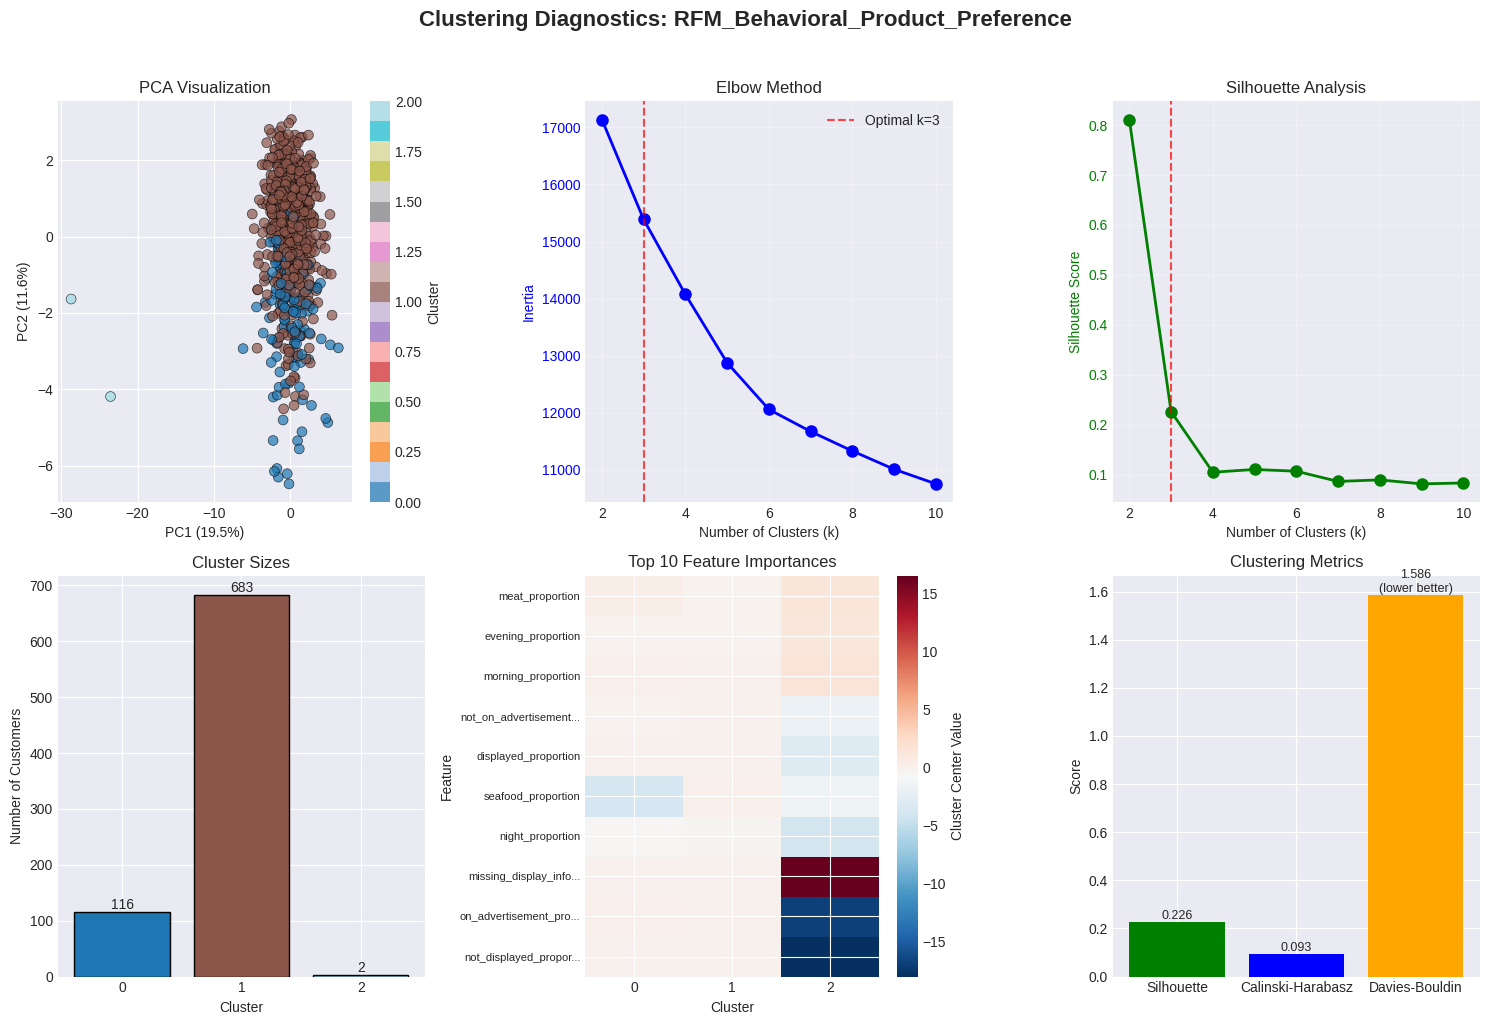

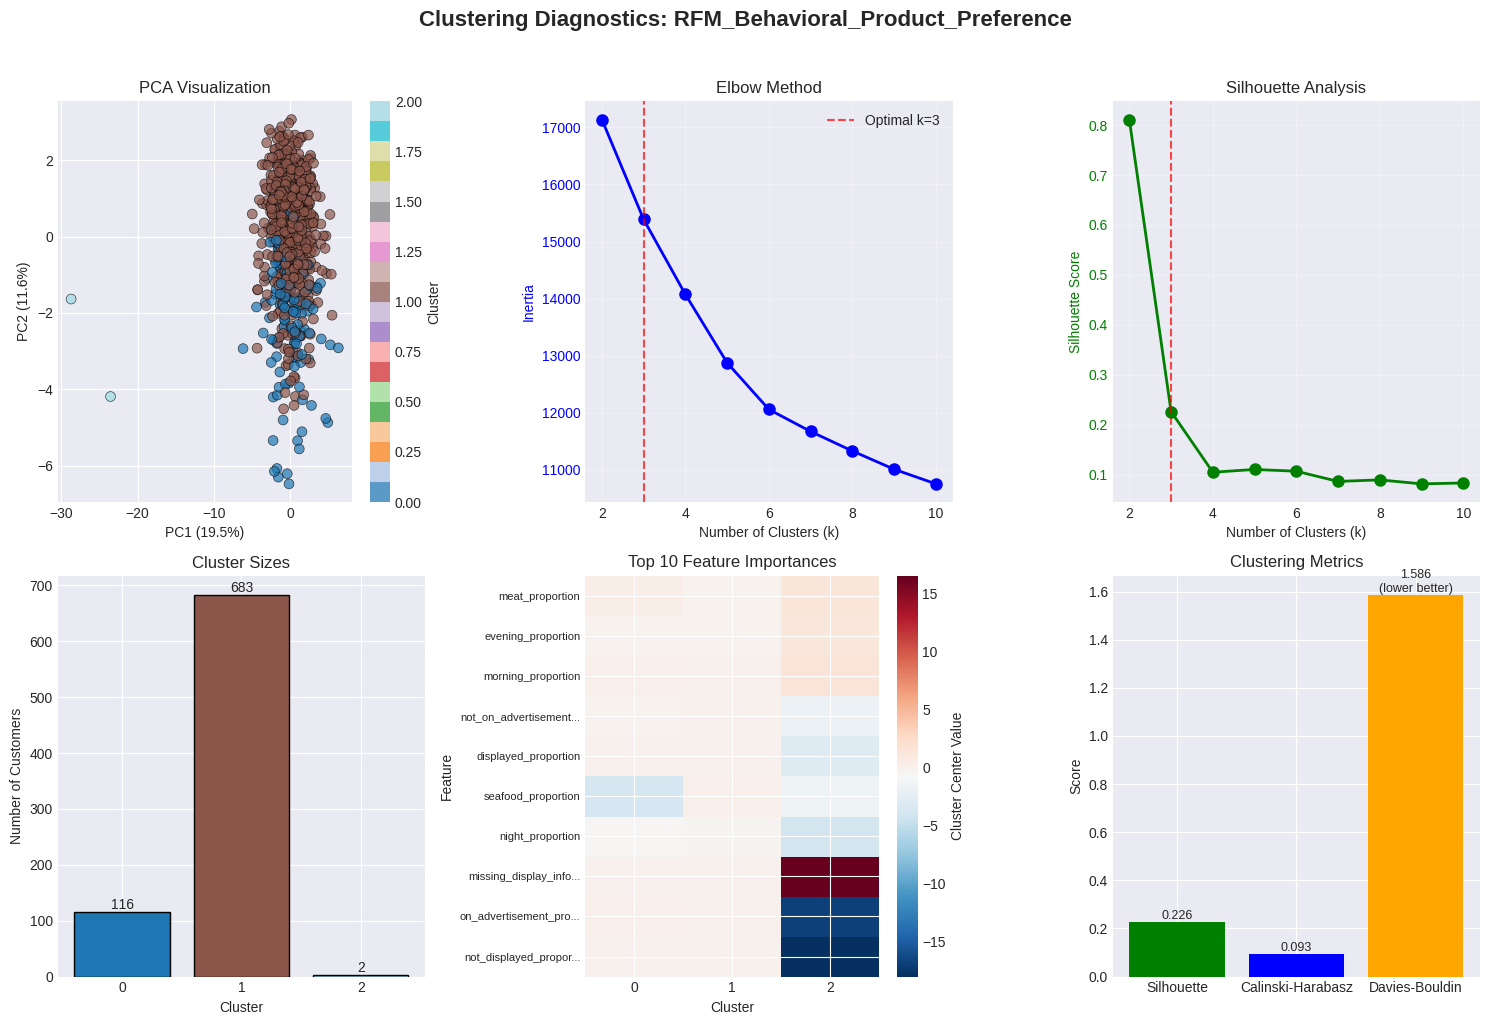

In [31]:
print("=" * 80)
print("RFM_Behavioral_Product_Preference CLUSTERING ANALYSIS")
print("=" * 80)

# Run basic RFM clustering
rfm_result = pipeline.cluster_with_kmeans('RFM_Behavioral_Product_Preference')

# Display results
print(f"\nRFM Clustering Results:")
print(f"Number of clusters: {rfm_result['metrics']['n_clusters']}")
print(f"Silhouette score: {rfm_result['metrics']['silhouette_score']:.3f}")
print(f"Calinski-Harabasz: {rfm_result['metrics']['calinski_harabasz_score']:.1f}")
print(f"Davies-Bouldin: {rfm_result['metrics']['davies_bouldin_score']:.3f}")

print("\nCluster sizes:")
print(rfm_result['cluster_stats'].to_string(index=False))

# Plot diagnostics
pipeline.plot_clustering_diagnostics('RFM_Behavioral_Product_Preference')

## Cell 9: Hyperparameter Tuning for RFM_Behavioral_Product_Preference

In [32]:
print("=" * 80)
print("RFM_Behavioral_Product_Preference HYPERPARAMETER TUNING")
print("=" * 80)

# Tune hyperparameters for RFM_Behavioral_Product_Preference
rfm_tuning = pipeline.tune_kmeans_hyperparameters('RFM_Behavioral_Product_Preference', n_iter=15)

print(f"\nBest parameters: {rfm_tuning['metrics']['best_params']}")
print(f"Best silhouette score: {rfm_tuning['metrics']['silhouette_score']:.3f}")
print(f"Tuned vs Original: {rfm_tuning['metrics']['silhouette_score']:.3f} vs {rfm_result['metrics']['silhouette_score']:.3f}")

# Compare methods
print("\nComparison of clustering methods for RFM_Behavioral_Product_Preference:")
comparison_df = pipeline.compare_clustering_methods('RFM_Behavioral_Product_Preference')
print(comparison_df.to_string(index=False))

RFM_Behavioral_Product_Preference HYPERPARAMETER TUNING

Best parameters: {'tol': 0.001, 'n_clusters': 8, 'max_iter': 400, 'init': 'random', 'algorithm': 'elkan'}
Best silhouette score: 0.084
Tuned vs Original: 0.084 vs 0.226

Comparison of clustering methods for RFM_Behavioral_Product_Preference:
       Method  k      Inertia  Silhouette  Calinski-Harabasz  Davies-Bouldin
K-means (k=3)  3 15386.309713    0.226146          93.175707        1.586388
K-means (k=5)  5 12874.899950    0.110135          94.353289        1.834509
K-means (k=6)  6 12057.718531    0.106596          91.272845        1.770021
K-means (k=4)  4 14072.613459    0.104550          92.631063        1.942273
Tuned K-means  8 11348.170574    0.084336          76.180179        1.850863


## Cell 10: Run Comprehensive Analysis on Multiple Groups


In [33]:
print("=" * 80)
print("COMPREHENSIVE FEATURE GROUP ANALYSIS")
print("=" * 80)

feature_groups_to_analyze = ['RFM', 'RFM_Product_Preference', 'Customer_Behavior', 'RFM_Behavioral_Product_Preference']

all_results = []

for group in feature_groups_to_analyze:
    print(f"\n{'='*60}")
    print(f"ANALYZING: {group}")
    print(f"{'='*60}")

    try:
        # Run clustering
        result = pipeline.cluster_with_kmeans(group)

        # Store results
        all_results.append({
            'Feature Group': group,
            'Num Clusters': result['metrics']['n_clusters'],
            'Silhouette': result['metrics']['silhouette_score'],
            'Calinski-Harabasz': result['metrics']['calinski_harabasz_score'],
            'Davies-Bouldin': result['metrics']['davies_bouldin_score'],
            'Inertia': result['metrics']['inertia'],
            'Cluster Sizes': str(result['cluster_stats']['size'].tolist())
        })

        print(f"✓ Completed: Silhouette = {result['metrics']['silhouette_score']:.3f}")

    except Exception as e:
        print(f"✗ Error: {str(e)}")
        all_results.append({
            'Feature Group': group,
            'Num Clusters': 'Error',
            'Silhouette': 'Error',
            'Calinski-Harabasz': 'Error',
            'Davies-Bouldin': 'Error',
            'Inertia': 'Error',
            'Cluster Sizes': 'Error'
        })

# Display summary
print(f"\n{'='*80}")
print("ANALYSIS SUMMARY")
print("="*80)

summary_df = pd.DataFrame(all_results)
if 'Silhouette' in summary_df.columns:
    # Convert to numeric for sorting
    summary_df['Silhouette_num'] = pd.to_numeric(summary_df['Silhouette'], errors='coerce')
    summary_df = summary_df.sort_values('Silhouette_num', ascending=False)
    summary_df = summary_df.drop('Silhouette_num', axis=1)

print(summary_df.to_string(index=False))

# Find best group
best_group_row = summary_df[summary_df['Silhouette'] != 'Error'].iloc[0]
print(f"\nBest performing group: {best_group_row['Feature Group']}")
print(f"Silhouette score: {best_group_row['Silhouette']:.3f}")
print(f"Number of clusters: {best_group_row['Num Clusters']}")

COMPREHENSIVE FEATURE GROUP ANALYSIS

ANALYZING: RFM
Optimal k for RFM: 3
✓ Completed: Silhouette = 0.292

ANALYZING: RFM_Product_Preference
Optimal k for RFM_Product_Preference: 2
✓ Completed: Silhouette = 0.370

ANALYZING: Customer_Behavior
Optimal k for Customer_Behavior: 3
✓ Completed: Silhouette = 0.150

ANALYZING: RFM_Behavioral_Product_Preference
Optimal k for RFM_Behavioral_Product_Preference: 3
✓ Completed: Silhouette = 0.226

ANALYSIS SUMMARY
                    Feature Group  Num Clusters  Silhouette  Calinski-Harabasz  Davies-Bouldin      Inertia   Cluster Sizes
           RFM_Product_Preference             2    0.369844         244.048806        1.267626  5701.152955      [117, 684]
                              RFM             3    0.291685         442.489013        1.172025   637.549972 [288, 281, 232]
RFM_Behavioral_Product_Preference             3    0.226146          93.175707        1.586388 15386.309713   [116, 683, 2]
                Customer_Behavior             3

## Cell 11: Export Results

In [34]:
print("=" * 80)
print("EXPORTING RESULTS")
print("=" * 80)

# Export all results to Google Drive
output_path = '/content/drive/MyDrive/Colab Notebooks/clustering_results'
pipeline.export_clustering_results(output_path)

print(f"\nResults saved to: {output_path}")
print("\nFiles created:")
for root, dirs, files in os.walk(output_path):
    level = root.replace(output_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f'{subindent}{file}')

EXPORTING RESULTS
Results exported to /content/drive/MyDrive/Colab Notebooks/clustering_results/
Timestamp: 20251218_102000

Results saved to: /content/drive/MyDrive/Colab Notebooks/clustering_results

Files created:
clustering_results/
  best_models/
    RFM_best_model_20251216_004227.csv
    RFM_best_model_20251216_004247.csv
    RFM_best_model_20251216_051239.csv
    RFM_best_model_20251216_204828.csv
    RFM_best_model_20251216_210436.csv
    RFM_Behavioral_Product_Preference_best_model_20251218_083725.csv
    RFM_Behavioral_Product_Preference_best_model_20251218_093223.csv
    RFM_Behavioral_Product_Preference_best_model_20251218_101721.csv
    RFM_Behavioral_Product_Preference_best_model_20251218_102000.csv
  RFM/
    clusters_20251216_004247.csv
    cluster_centers_20251216_004247.csv
    cluster_stats_20251216_004247.csv
    metrics_20251216_004247.csv
    cluster_profiles_20251216_004247.csv
    clusters_20251216_051239.csv
    cluster_centers_20251216_051239.csv
    cluster_s

## Cell 12: Advanced Analysis on Best Group

ADVANCED ANALYSIS FOR BEST GROUP: RFM_Product_Preference

Cluster Profiles for RFM_Product_Preference:
 cluster  size
       1   684
       0   117

Top Distinguishing Features per Cluster:

Cluster 0 (Size: 117.0):
  • seafood_proportion: z-score = -2.23
  • health_personal_care_proportion: z-score = 1.18
  • general_grocery_proportion: z-score = 1.17
  • produce_proportion: z-score = 0.74
  • monetary: z-score = -0.55

Cluster 1 (Size: 684.0):
  • seafood_proportion: z-score = 0.38
  • health_personal_care_proportion: z-score = -0.20
  • general_grocery_proportion: z-score = -0.20
  • produce_proportion: z-score = -0.13
  • monetary: z-score = 0.09


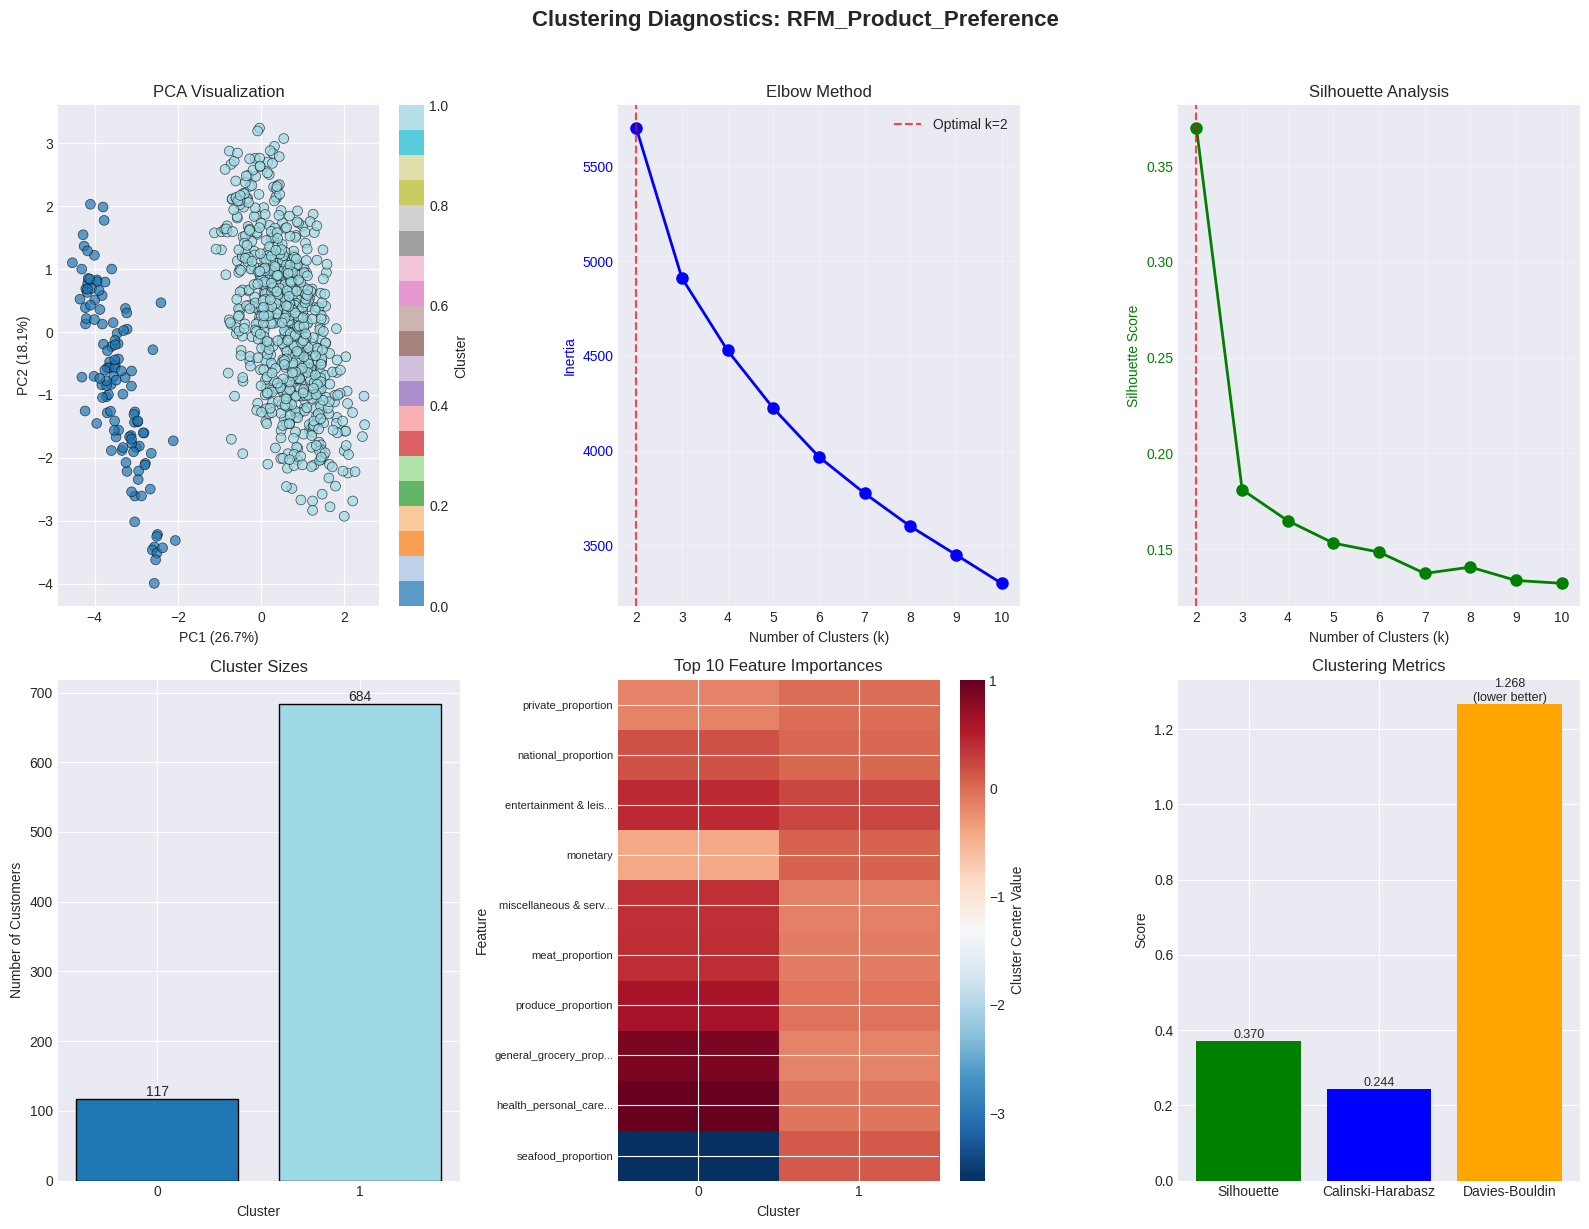

In [35]:
# Identify best performing group from summary
if 'summary_df' in locals():
    best_group = summary_df.iloc[0]['Feature Group']

    print("=" * 80)
    print(f"ADVANCED ANALYSIS FOR BEST GROUP: {best_group}")
    print("=" * 80)

    # Get cluster profiles
    profiles = pipeline.analyze_cluster_profiles(best_group)

    print(f"\nCluster Profiles for {best_group}:")
    print(profiles[['cluster', 'size']].to_string(index=False))

    # Show top features for each cluster
    print(f"\nTop Distinguishing Features per Cluster:")

    for cluster in sorted(profiles['cluster'].unique()):
        cluster_data = profiles[profiles['cluster'] == cluster].iloc[0]

        # Find z-score columns
        zscore_cols = [col for col in profiles.columns if col.endswith('_zscore')]
        cluster_zscores = {col: cluster_data[col] for col in zscore_cols}

        # Sort by absolute z-score
        sorted_features = sorted(cluster_zscores.items(), key=lambda x: abs(x[1]), reverse=True)

        print(f"\nCluster {cluster} (Size: {cluster_data['size']}):")
        for feat_zscore, zscore in sorted_features[:5]:  # Top 5 features
            feat_name = feat_zscore.replace('_zscore', '')
            print(f"  • {feat_name}: z-score = {zscore:.2f}")

    # Create detailed visualization for best group
    fig = pipeline.plot_clustering_diagnostics(best_group, figsize=(16, 12))

## Cell 13: Custom Analysis Cell (Use for Experimentation)

In [36]:
# Use this cell for custom experiments and analysis

# Example: Compare specific feature groups
groups_to_compare = ['RFM_Demographics', 'RFM_Product_Preference', 'Behavioral_All']

for group in groups_to_compare:
    print(f"\nAnalyzing {group}...")
    result = pipeline.cluster_with_kmeans(group)
    print(f"  Silhouette: {result['metrics']['silhouette_score']:.3f}")
    print(f"  Clusters: {result['metrics']['n_clusters']}")

# Example: Run hierarchical k selection
print("\n\nHierarchical k selection for RFM:")
hierarchical_result = pipeline.hierarchical_k_selection('RFM', min_k=2, max_k=10)
print(f"Best k: {hierarchical_result['best_k']}")

# Example: Create custom parameter grid
custom_param_grid = {
    'n_clusters': range(3, 8),
    'init': ['k-means++'],
    'max_iter': [300, 400, 500],
    'tol': [1e-4, 1e-3],
    'algorithm': ['lloyd']
}

print("\n\nCustom hyperparameter tuning:")
custom_tuning = pipeline.tune_kmeans_hyperparameters(
    'RFM_Demographics',
    param_grid=custom_param_grid,
    n_iter=10
)
print(f"Best parameters: {custom_tuning['metrics']['best_params']}")
print(f"Best score: {custom_tuning['metrics']['best_score']:.3f}")


Analyzing RFM_Demographics...


ValueError: Feature group 'RFM_Demographics' not found. Available groups: ['RFM', 'Demographics', 'Customer_Behavior', 'Product_Preference', 'RFM_Demographic', 'RFM_Customer_Behavior', 'RFM_Product_Preference', 'RFM_Demographic_Customer_Behavior', 'RFM_Demographic_Product_Preference', 'RFM_Behavioral_Product_Preference', 'All_Features']

In [37]:
# First, upgrade key packages
!pip install -q -U transformers accelerate bitsandbytes

# Verify GPU
!nvidia-smi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.3 MB/s eta 0:00:00
Thu Dec 18 10:20:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                  

In [38]:
from huggingface_hub import login

# Method 1: Interactive login (recommended for first time)
login()

# Method 2: Use token directly (if you have it)
# login(token="hf_your_token_here")

## Llama-3.1-8B-Instruct

In [39]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

# Configure 4-bit quantization to fit in Colab memory
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

# Load the tokenizer and model
model_name = "meta-llama/Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",  # Automatically places layers on GPU/CPU
    torch_dtype=torch.float16,
)

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [40]:
def chat_with_llama(messages, max_new_tokens=512):
    """Format messages for Llama 3.1 Instruct"""

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode and return
    response = tokenizer.decode(outputs[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
    return response

In [41]:
# Example cluster interpretation
cluster_profile = """
Cluster 2 Profile:
- Average Purchase Value: $850 (High)
- Purchase Frequency: 0.5/month (Low)
- Customer Lifetime: 24 months (Long)
- Engagement Score: 15/100 (Very Low)
- Product Categories: Premium, Enterprise
- Top Features: "price_sensitivity" (low), "support_tickets" (high)
"""

messages = [
    {"role": "system", "content": "You are a helpful data analyst assistant."},
    {"role": "user", "content": f"""Based on this cluster profile, please provide:
1. A descriptive name for this customer segment (2-4 words)
2. Key characteristics in business terms
3. 2-3 targeted marketing recommendations

{cluster_profile}"""}
]

response = chat_with_llama(messages)
print(response)

**1. Descriptive Name:** "Premium Loyal but Disengaged"

**2. Key Characteristics in Business Terms:**

- **High-value customers:** This segment consists of customers who consistently make large purchases, with an average order value of $850.
- **Low purchase frequency:** Despite their high average order value, these customers only make purchases about 0.5 times per month, indicating a relatively low purchase frequency.
- **Long-term relationships:** The average customer lifetime is 24 months, suggesting a high level of customer retention.
- **Low engagement:** This segment has a very low engagement score of 15/100, indicating a lack of interaction with the brand.
- **Focus on premium and enterprise products:** These customers are interested in premium and enterprise products, indicating a high level of demand for advanced features and services.

**3. Targeted Marketing Recommendations:**

1.  **Personalized Support and Engagement:** Given their low engagement score, consider offering 

## Ollama LLM


In [45]:
# 1. Install Ollama in Colab
!curl -fsSL https://ollama.com/install.sh | sh

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [48]:
# Start Ollama server in background
!ollama serve > /tmp/ollama.log 2>&1 &

# Wait for server to start
import time
time.sleep(10)

# Check if server is running
!ps aux | grep -E "ollama serve|ollama" | grep -v grep

root       27459  0.2  0.2 1856412 31312 ?       Sl   11:06   0:00 ollama serve


In [49]:
# Pull a smaller model that definitely works on Colab T4 GPU
!ollama pull mistral:7b-instruct-q4_0

In [50]:
# Check available models
!ollama list

# Test server connection
!curl http://localhost:11434/api/tags

NAME                        ID              SIZE      MODIFIED           
mistral:7b-instruct-q4_0    b17615239298    4.1 GB    About a minute ago    
{"models":[{"name":"mistral:7b-instruct-q4_0","model":"mistral:7b-instruct-q4_0","modified_at":"2025-12-18T11:08:25.731123921Z","size":4109865192,"digest":"b17615239298ea5bacfc1c46aa1842737b833779c805542b78f6be29c516d2f4","details":{"parent_model":"","format":"gguf","family":"llama","families":["llama"],"parameter_size":"7B","quantization_level":"Q4_0"}}]}

In [51]:
!pip install ollama -q

import ollama
import json

def get_cluster_insights(cluster_summary):
    """Get LLM insights for a cluster"""

    prompt = f"""
    Analyze this customer cluster profile:
    {cluster_summary}

    Provide in JSON format:
    {{
      "segment_name": "2-4 word descriptive name",
      "key_characteristics": ["trait1", "trait2", "trait3"],
      "recommended_actions": ["action1", "action2"]
    }}
    """

    try:
        response = ollama.chat(
            model='mistral:7b-instruct-q4_0',
            messages=[
                {'role': 'system', 'content': 'You are a data analyst.'},
                {'role': 'user', 'content': prompt}
            ],
            options={'temperature': 0.1, 'format': 'json'}
        )

        # Parse JSON response
        insights = json.loads(response['message']['content'])
        return insights

    except Exception as e:
        return {"error": str(e)}

# Test with example cluster data
example_cluster = """
- Average purchase value: $850 (high)
- Purchase frequency: 0.5/month (low)
- Engagement score: 15/100 (very low)
- Customer lifetime: 24 months (long)
- Product preference: Premium products
"""

print("Analyzing cluster...")
result = get_cluster_insights(example_cluster)
print(json.dumps(result, indent=2))

Analyzing cluster...
{
  "segment_name": "Premium Customers",
  "key_characteristics": [
    "High purchase value",
    "Low purchase frequency",
    "Very low engagement score",
    "Long customer lifetime",
    "Premium product preference"
  ],
  "recommended_actions": [
    "Offer personalized promotions and discounts to incentivize purchases",
    "Improve customer service and engagement strategies to increase customer satisfaction"
  ]
}
